### Configurations and Libraries



In [ ]:
# TODO: change from mounting drive to local files
# TODO: add tests

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd drive/MyDrive/gsoc-evaluation-task/

/content/drive/MyDrive/gsoc-evaluation-task


In [3]:
%ls

data/  model/  README.md


In [51]:
%pip install -q seaborn_image

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.3/332.3 kB 8.1 MB/s eta 0:00:00


In [52]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from numpy.typing import NDArray
import seaborn as sns
import seaborn_image as isns
from sklearn.metrics import roc_curve, auc

### Load & Describe Data

In [144]:
data_path = Path('data')
model_path = Path('model')

In [145]:
images = np.load(data_path / 'images.npy')
labels = np.load(data_path / 'labels.npy')

In [151]:
print(f"Data type of images: {images.dtype}")
print(f"Data type of labels: {labels.dtype}")

Data type of images: float64
Data type of labels: int64


In [152]:
# TODO: can we keep generic? what if it's a string?
def labels_description(data: NDArray[np.int64]) -> None:
  df = pd.DataFrame(data)
  print(df.describe())
  print(df.info())

def slice_description(data: NDArray[np.float64]) -> None:
  slice = data[0, :, :].reshape(256,)
  df = pd.DataFrame(slice)
  print(df.describe())
  print(df.info())

In [153]:
slice_description(images)

                0
count  256.000000
mean     0.955877
std      0.908362
min      0.007223
25%      0.306411
50%      0.691741
75%      1.343379
max      6.263326
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256 entries, 0 to 255
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       256 non-null    float64
dtypes: float64(1)
memory usage: 2.1 KB
None


In [155]:
labels_description(labels)

                0
count  1000.00000
mean      0.50000
std       0.50025
min       0.00000
25%       0.00000
50%       0.50000
75%       1.00000
max       1.00000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   0       1000 non-null   int64
dtypes: int64(1)
memory usage: 7.9 KB
None


### Data Visualization

In [156]:
# TODO: check the type of pixels
def print_random_image(images: NDArray[np.float64], labels: NDArray[np.int64]) -> None:
  index = np.random.randint(0, images.shape[0])
  plt.imshow(images[index])
  plt.title(f'Label: {labels[index]}')
  plt.show()

def print_image_distribution(images: NDArray[np.float64], labels: NDArray[np.int64]) -> None:
  index = np.random.randint(0, images.shape[0])
  ax = isns.imghist(images[index])
  plt.title(f'Index: {index}, Label: {labels[index]}')

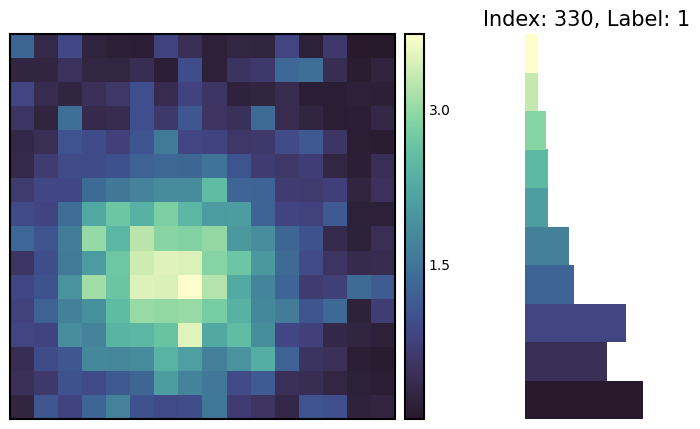

In [157]:
# TODO: histogram of pixel intensities using seaborn (or alternatives)
print_image_distribution(images, labels)

### Provided Model's Predictions

In [158]:
# TODO: again be coherent with the same format, especially if we consider quantization
# TODO: move in utils.py
def predict(model: tf.keras.Model, images: NDArray[np.float64]) -> NDArray[np.float32]:
  input_tensor = tf.convert_to_tensor(images, dtype=tf.float32)
  output = infer(input_tensor)
  return output['lambda'].numpy()

def normalize_matrix(matrix: NDArray[np.float32]) -> NDArray[np.float32]:
  min_score = np.min(output)
  max_score = np.max(output)
  normalized_output = []
  for score in output:
    normalized_output.append((score - min_score)/(max_score-min_score))
  return normalized_output

In [159]:
def plot_roc_curve(labels: NDArray[np.int32], output: NDArray[np.float32]) -> None:
  fpr, tpr, thresholds = roc_curve(labels, output)
  roc_auc = auc(fpr, tpr)
  # Plotting the ROC curve
  plt.figure(figsize=(8, 6))
  plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # diagonal line (random classifier)

  # Add labels and title
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic (ROC) Curve')
  plt.legend(loc="lower right")

  # Show plot
  plt.show()

In [160]:
#keras_model = tf.keras.models.load_model('model')
#keras_model = tf.keras.layers.TFSMLayer(model_path, call_endpoint = 'serving_default')ù
model = tf.saved_model.load(model_path)
infer = model.signatures['serving_default']

In [168]:
output = predict(model, images)

In [169]:
normalized_output = normalize_matrix(output)

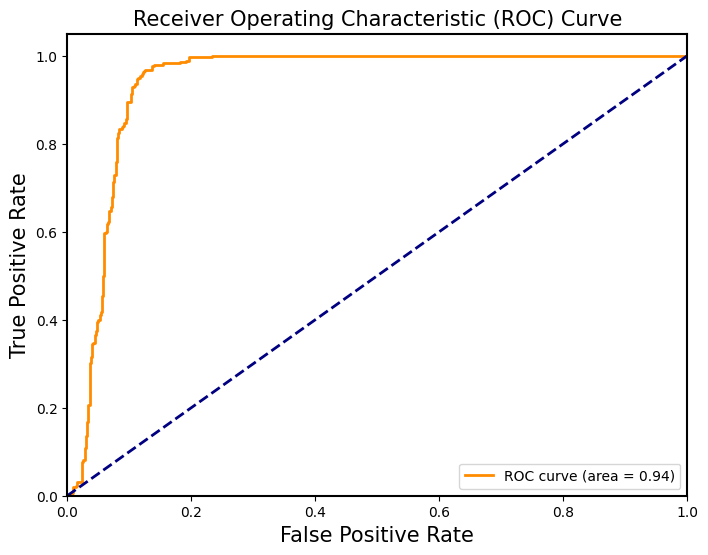

In [170]:
plot_roc_curve(labels, normalized_output)